In [6]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags, csr_matrix, kron
from scipy.linalg import solve_sylvester, schur, expm
from scipy.sparse.linalg import spsolve, cg
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time

In [12]:
def plot_sol(X,Y,U):
    plt.figure(0)
    ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(U, -1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot3D(xline, yline, zline)

def compute_err(U, U_exact):
    error_inf = 0
    error_sq = 0
    for i in range(0,n):
        for j in range(0,n):
            error_sq += np.absolute(U_exact[i][j] - U[i][j])**2
            if np.absolute(U_exact[i][j] - U[i][j]) > error_inf:
                error_inf = np.absolute(U_exact[i][j] - U[i][j])
        
    error_sq = (error_sq * h**2)**0.5
    return error_inf, error_sq


In [17]:
def kron_prod_direct(T,F):
    start_time = time.time()
    F = np.reshape(F,-1)
    A = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n)) #A = I kron T + T^t kron I
    kron_time = time.time() - start_time
    U = spsolve(A, F) #Solve using scipy sparse solver
    #U, info = gmres(A, F, tol=1e-9)
    end_time = time.time()
    solve_time = end_time - kron_time
    total_time = end_time - start_time
    timings = [kron_time, solve_time, total_time]
    return U, timings


def scipy_solver(T, F):
    start_time = time.time()
    U = solve_sylvester(T, T, F)
    end_time = time.time()
    total_time = end_time - start_time
    return U, total_time

def bartels_stewart(T, F):
    start_time = time.time()
    R, P = schur(T) #Compute Schur decomposition
    R_trans = R.transpose()
    schur_time = time.time() - start_time

    #Solve R^*V + VR = P^*FP for V
    V = np.empty([n,n])
    RHS = np.matmul(np.matmul(P.transpose(),F),P)
    for i in range(0,n):
        for j in range(0,n):
            sum1 = 0
            sum2 = 0
            
            for a in range(0,i-1):
                sum1 += R_trans[i][a]*V[a][j]
            for b in range(0,j-1):
                sum2 += V[i][b]*R[b][j]
                
            V[i][j] = (RHS[i][j] - sum1 - sum2)/(R_trans[i][i]+R[j][j])
    V_time = time.time() - schur_time
            
    U = np.matmul(np.matmul(P,V),P.transpose()) #Compute U=PVP^*
    end_time = time.time()
    solve_time = end_time - V_time
    total_time = end_time - start_time
    timings = [schur_time, V_time, solve_time, total_time]
    return U, timings

def hessenberg_schur(T, F):
    start_time = time.time()
    eigvals, eigvecs = np.linalg.eig(T) #Get eigenvalues and eigenvectors of T
    eig_time = time.time() - start_time
    diag = diags(eigvals, 0, shape=(n, n)).toarray() #Set eigenvalues as diagonal matrix
    P = eigvecs #Set basis matrix P, with columns as the eigenvectors
    diag_time = time.time() - eig_time
    F_hat = np.matmul(np.matmul(np.linalg.inv(P),F),P) #F_hat = P^-1 * F * P
    F_time = time.time() - diag_time

    U_hat = np.empty([n,n]) #u_hat(i,j) = f(i,j) / eigval(i) + eigval(j)
    for i in range(0,n):
        for j in range(0,n):
            if (eigvals[i]!=0 or eigvals[j]!=0):
                U_hat[i][j] = F_hat[i][j] / (eigvals[i]+eigvals[j])
            else:
                U_hat[i][j] = 0

    U_time = time.time() - F_time
    U = np.matmul(np.matmul(P,U_hat),np.linalg.inv(P)) #U = P * U^hat * P^-1
    end_time = time.time()
    solve_time = end_time - U_time
    total_time = end_time - start_time
    timings = [eig_time, diag_time, F_time, U_time, solve_time, total_time]
    return U, timings

def hessenberg_schur_explicit(T, F):
    start_time = time.time()
    eigvals = np.empty(n)
    eigvecs = np.empty([n,n])

    for i in range(0,n):
        eigvals[i] = (T[0][0] - T[0][0]*np.cos((i+1)*np.pi/(n+1)))
        for j in range(0,n):
            eigvecs[i][j] = np.sqrt(2/(n+1))*np.sin(((i+1)*(j+1)*np.pi)/(n+1))
    eig_time = time.time() - start_time
    diag = diags(eigvals, 0, shape=(n, n)).toarray() #Set eigenvalues as diagonal matrix
    P = eigvecs #Set basis matrix P, with columns as the eigenvectors
    diag_time = time.time() - eig_time
    F_hat = np.matmul(np.matmul(np.linalg.inv(P),F),P) #F_hat = P^-1 * F * P
    F_time = time.time() - diag_time

    U_hat = np.empty([n,n]) #u_hat(i,j) = f(i,j) / eigval(i) + eigval(j)
    for i in range(0,n):
        for j in range(0,n):
            if (eigvals[i]!=0 or eigvals[j]!=0):
                U_hat[i][j] = F_hat[i][j] / (eigvals[i]+eigvals[j])
            else:
                U_hat[i][j] = 0

    U_time = time.time() - F_time
    U = np.matmul(np.matmul(P,U_hat),np.linalg.inv(P)) #U = P * U^hat * P^-1
    end_time = time.time()
    solve_time = end_time - U_time
    total_time = end_time - start_time
    timings = [eig_time, diag_time, F_time, U_time, solve_time, total_time]
    return U, timings

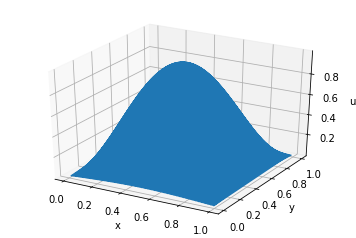

In [21]:
#Define parameters
n = 100 #number of internal nodes in each direction (number of unknowns)
h = 1/(n+1) #step size

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define F 
F = 2 * np.pi**2 * np.sin(np.pi*X) * np.sin(np.pi*Y)  

#Define tridiagonal matrix T
diagonals = [[-2],[1],[1]]
T = np.multiply((-1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())

#Compute exact solution for comparison
U_exact = np.sin(np.pi*X) * np.sin(np.pi*Y)

U, timings = hessenberg_schur_explicit(T, F)
plot_sol(X,Y,U)
